In [ ]:
%load_ext autoreload
%autoreload 2

<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-loader" data-toc-modified-id="Data-loader-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data loader</a></span></li></ul></div>

# Подключение библиотек

In [2]:
import fiftyone as fo
import fiftyone.zoo as foz
from dataset import FiftyOneTorchDataset

# Download and load the validation split of COCO-2017
fo_dataset = foz.load_zoo_dataset("coco-2017", split="validation",
                               dataset_dir='/mnt/heap')

Found annotations at '/mnt/heap/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |███████████████| 5000/5000 [22.7s elapsed, 0s remaining, 226.0 samples/s]      
Dataset 'coco-2017-validation' created


session = fo.launch_app(dataset)

In [3]:
fo_dataset.compute_metadata()

## Data set

In [4]:
import torch
from viewer import Viewer
from PIL import Image

In [5]:
viewer = Viewer()

In [6]:
from fiftyone import ViewField as F

person_list = ['person','car']
person_view = fo_dataset.filter_labels("ground_truth",
        F("label").is_in(person_list)).match(F("ground_truth.detections").length() == 1)
print(len(person_view))

1014


## Data loader

In [7]:
import torchvision.transforms as T

img_size = (256, 256)
train_transforms = T.Compose([T.Resize(img_size),
                              T.ToTensor()])
test_transforms = T.Compose([T.Resize(img_size),
                             T.ToTensor()])

In [8]:
# split the dataset in train and test set
train_view = person_view.take(len(person_view) * 0.75, seed=51)
test_view = person_view.exclude([s.id for s in train_view])

In [9]:
torch_dataset = FiftyOneTorchDataset(train_view, train_transforms,
        classes=person_list)
torch_dataset_test = FiftyOneTorchDataset(test_view, test_transforms, 
        classes=person_list)

In [10]:
len(torch_dataset)

760

In [11]:
len(torch_dataset_test)

254

In [12]:
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
        torch_dataset, batch_size=64)
    
data_loader_test = torch.utils.data.DataLoader(
        torch_dataset_test, batch_size=64, shuffle=False)

# Train loop

In [13]:
from itertools import product
from pytorch_helper import PyTorchHelper

In [14]:
loss_function_xy = torch.nn.MSELoss()
loss_function_bce = torch.nn.CrossEntropyLoss()

In [15]:
from extended_model import ExtendedModel

In [16]:
from pytorch_helper import PyTorchHelper

def find_hyperparameters(config):
    learning_rates = [1e-1]
    anneal_coeff = 0.2
    anneal_epochs = [10]
    regs = config['regs']
    optimizers = config['optimizers']

    batch_size = 64
    epoch_num = 20

    run_record = {} 
    
    helper = PyTorchHelper(8,  None)

    lenet_model = None
    val_loss = 8
    loss_history = None
    for lr, reg, anneal_epoch, optimizer in product(learning_rates, regs, anneal_epochs, optimizers):
        
        lenet_model = ExtendedModel(config['model'](), config['need_train'], config['model_name'])
        if not lenet_model.need_train:
            if lenet_model.load_model():
                return lenet_model
        
        optimizer = optimizer(lenet_model.torch_model.parameters(), lr=lr, weight_decay=reg)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epoch, gamma=anneal_coeff)

        model, train_loss_history, val_loss_history, train_metric_history, val_metric_history = helper.train_model(lenet_model.torch_model, data_loader, data_loader_test, optimizer, epoch_num, scheduler)
        lenet_model.add_history(train_loss_history, val_loss_history, train_metric_history, val_metric_history)

    return lenet_model

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision.models import resnet18

In [18]:
def net():
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(in_features=512, out_features=5)
    return model

In [28]:
config = {
    'need_train': True,
    'regs': [0.001],
    'optimizers': [optim.Adam],
    'model': net,
    'model_name': 'best_lenet'    
}

In [29]:
from resource_monitor import ResourceMonitor
resourceMonitor = ResourceMonitor()

In [30]:
resourceMonitor.print_statistics('MB')

memory_allocated: 0.0
max_memory_allocated: 0.0
memory_reserved: 0.0
max_memory_reserved: 0.0


In [33]:
extended_model = find_hyperparameters(config)

Start train:
memory_allocated: 130.71533203125
max_memory_allocated: 130.71533203125
memory_reserved: 152.0
max_memory_reserved: 152.0
Epoch 0/19
----------
Step 0/12 Loss 1.749194860458374
Step 1/12 Loss 24.434553146362305
Step 2/12 Loss 21.204421997070312
Step 3/12 Loss 13.964116096496582
Step 4/12 Loss 5.91119909286499
Step 5/12 Loss 3.7705578804016113
Step 6/12 Loss 3.0688891410827637
Step 7/12 Loss 2.995577812194824
Step 8/12 Loss 3.5960910320281982


KeyboardInterrupt: 

In [23]:
from matplotlib import pyplot as plt

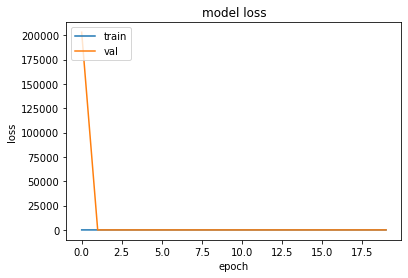

In [24]:
viewer.visualize_loss_history(extended_model)

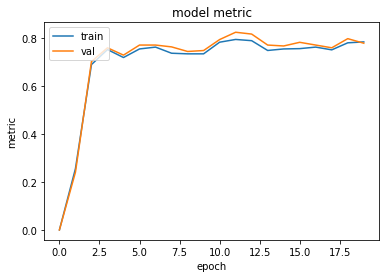

In [25]:
viewer.visualize_metric_history(extended_model)

In [26]:
resourceMonitor.print_statistics('MB')

memory_allocated: 0.0
max_memory_allocated: 0.0
memory_reserved: 0.0
max_memory_reserved: 0.0


In [27]:
===============================================

SyntaxError: invalid syntax (<ipython-input-27-4873ce4e3145>, line 1)

In [ ]:
def predict(index):
    img, target = torch_dataset[index]
    pred = extended_model.torch_model(img.unsqueeze(0))[0]
    
    original_img = Image.open(target['img_path']).convert("RGB")
    viewer.print_prediction(original_img, target, pred)

In [ ]:
for i in range(10, 170):
    predict(i)

In [ ]:
===============================================

In [ ]:
===============================================

# Visualization

In [ ]:
import fiftyone as fo

def convert_torch_predictions(preds, det_id, s_id, w, h, classes):
    # Convert the outputs of the torch model into a FiftyOne Detections object
    dets = []
    #if preds[0] < 0.5:
     #   detections = fo.Detections(detections=dets)
      #  return detections, det_id
    
    # Parse prediction into FiftyOne Detection object
    x0,y0,x1,y1 = preds[1:]
    coco_obj = fouc.COCOObject(det_id, s_id, int(1), [x0, y0, x1-x0, y1-y0])
    det = coco_obj.to_detection((w,h), classes)
    dets.append(det)
    det_id += 1
        
    detections = fo.Detections(detections=dets)
        
    return detections, det_id

def add_detections(model, torch_dataset, view, field_name="predictions"):
    # Run inference on a dataset and add results to FiftyOne
    torch.set_num_threads(1)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print("Using device %s" % device)

    model.eval()
    model.to(device)
    image_paths = torch_dataset.img_paths
    classes = torch_dataset.classes
    det_id = 0
    
    with fo.ProgressBar() as pb:
        for img, targets in pb(torch_dataset):
            sample = view[targets["img_path"]]
            s_id = sample.id
            w = sample.metadata["width"]
            h = sample.metadata["height"]
            
            # Inference
            preds = model(img.unsqueeze(0).to(device))[0]
            
            detections, det_id = convert_torch_predictions(
                preds, 
                det_id, 
                s_id, 
                w, 
                h, 
                classes,
            )
            
            sample["predictions"] = detections
            sample.save()

In [ ]:
add_detections(model, torch_dataset_test, fo_dataset)

In [ ]:
session = fo.launch_app(fo_dataset)